In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import datetime

In [2]:
train = pd.read_csv('./train.csv')
sub = pd.read_csv('./sample_submission.csv')

## Step 1: 월별 시계열 데이터 생성

In [3]:
monthly = train.groupby(['item_id', 'year', 'month']).agg({
    'value': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'hs4': 'first'
}).reset_index()

monthly['year_month'] = pd.to_datetime(
    monthly['year'].astype(str) + '-' + monthly['month'].astype(str),
    format='%Y-%m'
)

pivot_value = monthly.pivot_table(
    index='year_month',
    columns='item_id',
    values='value',
    fill_value=0
).sort_index()

# Transpose: item을 index로 (예시 코드 형식)
pivot = pivot_value.T  # (100 items × 43 months)

pivot.head(5)

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [4]:
item_to_hs4 = monthly.groupby('item_id')['hs4'].first().to_dict()

## Step 1.1: STL분해 및 residual only 패턴

In [5]:
from statsmodels.tsa.seasonal import STL

# ==============================
# STL residual pivot 만들기
# ==============================

def extract_residual(series, period=12):
    """
    pivot.loc[item_id] 1개 시계열을 받아 residual만 반환
    """
    s = pd.Series(series)

    # 0 → NaN 처리 후 보간
    s = s.replace(0, np.nan).interpolate().fillna(method="bfill").fillna(method="ffill")

    stl = STL(s, period=period, robust=True).fit()
    return stl.resid

# residual pivot 생성
residual_pivot = pd.DataFrame(
    {
        item: extract_residual(pivot.loc[item])
        for item in pivot.index
    }
).T

print("원본 pivot:", pivot.shape)
print("Residual pivot:", residual_pivot.shape)

/tmp/ipython-input-246712618.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.replace(0, np.nan).interpolate().fillna(method="bfill").fillna(method="ffill")


원본 pivot: (100, 43)
Residual pivot: (100, 43)


In [7]:
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

pivot.to_csv(f"hs_pivot_{date_str}.csv",index=None,encoding='utf-8-sig')
residual_pivot.to_csv(f"hs_residual_pivot_{date_str}.csv",index=None,encoding='utf-8-sig')

In [8]:
residual_pivot.head()

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
AANGBULD,-342.036867,-1200.640105,9.460541e+02,7.418149e+02,-25.157784,-15.136140,-5.238517,5.025552,14.942206,23.953403,...,-8.946966e+00,-5.349774e+00,-1.978072e+00,-1.106895e+03,-2.780736e+02,7.427618e+02,2.082877e+02,1.128553e+01,1.402524e+01,1.680730e+01
AHMDUILJ,-5.086886,10.273423,-7.904667e+00,-5.451455e+00,-3.018755,-0.608440,1.780259,4.146654,6.481541,8.769821,...,1.025068e+02,8.770429e+01,7.039167e+01,8.323088e+01,3.716074e+01,1.086705e+01,-1.054974e+01,-3.253586e+01,-5.501658e+01,-7.793009e+01
ANWUJOKX,-5.158523,-3.602172,-2.065832e+00,-5.526820e-01,0.933210,2.385892,3.795919,6.774131,6.410659,7.519515,...,-4.069400e-01,-3.429602e-01,-2.753185e-01,-2.059632e-01,-1.356455e-01,-6.467539e-02,6.883006e-03,7.902426e-02,1.517579e-01,2.250834e-01
APQGTRMF,494.751680,343.901100,1.939665e+02,4.510317e+01,-102.480474,-248.463350,-392.309941,-533.130283,-851.420293,-795.376395,...,3.783521e+01,3.192481e+01,2.585748e+01,1.970795e+01,1.350912e+01,7.296536e+00,1.071145e+00,-5.168469e+00,-1.142411e+01,-1.769708e+01
ATLDMDBO,0.000003,0.000002,5.364418e-07,-3.725290e-07,-0.000001,-0.000002,-0.000002,-0.000003,-0.000003,-0.000002,...,-8.419156e-07,-9.685755e-07,-9.238720e-07,-7.376075e-07,-5.438924e-07,-2.980232e-07,-3.725290e-08,2.682209e-07,5.960464e-07,9.536743e-07


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 월 리스트 (나중에 Step 7에서도 씀) ---
months_dt = pivot.columns.to_list()

# === STL 분해 기반 trend_pivot, seasonal_pivot 생성 ===
trend_data = {}
seasonal_data = {}

for item_id in pivot.index:
    series = pivot.loc[item_id].astype(float)
    series_clean = series.fillna(0)

    try:
        decomposition = seasonal_decompose(series_clean, model='additive', period=12)
        trend_data[item_id] = decomposition.trend
        seasonal_data[item_id] = decomposition.seasonal
    except Exception as e:
        # 실패 시 NaN으로 채움
        trend_data[item_id] = pd.Series([np.nan] * len(series_clean), index=series_clean.index)
        seasonal_data[item_id] = pd.Series([np.nan] * len(series_clean), index=series_clean.index)

trend_pivot = pd.DataFrame(trend_data).T
seasonal_pivot = pd.DataFrame(seasonal_data).T

print("trend_pivot 및 seasonal_pivot 생성 완료.")

trend_pivot 및 seasonal_pivot 생성 완료.


## Step 2: HS4 매핑 및 유사도 함수

In [ ]:
# # 2-1. 품목별 HS4 매핑
# item_to_hs4 = monthly.groupby('item_id')['hs4'].first().to_dict()

# def hs4_similarity(item_a, item_b):
#     """
#     HS4 코드 앞자리 유사도 계산
#     예: 8471 vs 8473 -> 2자리 일치 -> 0.5
#     """
#     str_a = str(item_a).zfill(4)
#     str_b = str(item_b).zfill(4)

#     if str_a[:2] == str_b[:2]:  # 2자리 일치
#         return 0.5
#     elif str_a[:1] == str_b[:1]:  # 1자리 일치
#         return 0.3
#     return 0.0

## Step 3: 통계적 유의성 검증

In [10]:
from scipy.stats import pearsonr

def safe_corr_with_pvalue(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value) # 피어슨 상관계수, p-value

## Step 4: Granger Causality 검증

- A의 과거 정보가 B의 미래를 예측하는 데 도움이 되는가?"**를 통계적으로 검증하는 방법



```
# B의 과거 + A의 과거 사용
B(3월) = f(B의 1월, B의 2월, A의 1월, A의 2월)
B(4월) = f(B의 2월, B의 3월, A의 2월, A의 3월)
...

예측 오차 = 2  ← 더 정확!
```

**결론**
```
A의 정보를 추가했더니 예측이 더 정확해짐!
→ "A가 B를 Granger-cause 한다" ✅
```

---

🔬 통계적 검증

**가설 검정**
```
H0 (귀무가설): A의 과거 정보는 B 예측에 도움 안 됨
H1 (대립가설): A의 과거 정보는 B 예측에 도움 됨

→ F-test로 검증
→ p-value < 0.05 이면 H0 기각 → A가 B를 cause함!
```



In [11]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(x, y, max_lag=6):
    """
    x가 y를 Granger-cause 하는지 검증
    """
    try:
        data = pd.DataFrame({'x': x, 'y': y})
        test_result = grangercausalitytests(data[['y', 'x']],
                                            maxlag=max_lag,
                                            verbose=False)
        # 각 lag의 p-value 중 최소값 반환
        p_values = [test_result[lag][0]['ssr_ftest'][1]
                   for lag in range(1, max_lag+1)]
        return min(p_values)
    except:
        return 1.0


## Step 5: 공행성 강도 점수 계산

In [12]:
def calculate_score_advanced(corr, p_value, granger_p, lag):
    """
    정교한 공행성 점수 계산
    """

    # 1. 상관계수 점수 (0~50점) - 비선형 스케일링
    # 강한 상관관계에 더 높은 보상
    if abs(corr) >= 0.8:
        corr_score = 50
    elif abs(corr) >= 0.7:
        corr_score = 45
    elif abs(corr) >= 0.6:
        corr_score = 38
    elif abs(corr) >= 0.5:
        corr_score = 30
    else:
        corr_score = abs(corr) * 50  # 0.5 미만은 선형

    # 2. 통계적 유의성 점수 (0~25점) - 더 세분화
    if p_value < 0.001:
        sig_score = 25  # 매우 강한 유의성
    elif p_value < 0.01:
        sig_score = 20
    elif p_value < 0.05:
        sig_score = 12
    else:
        sig_score = 5  # 약한 유의성도 약간 점수

    # 3. Granger 인과성 점수 (0~20점) - 더 세분화
    if granger_p < 0.001:
        granger_score = 20  # 매우 강한 인과성
    elif granger_p < 0.01:
        granger_score = 16
    elif granger_p < 0.05:
        granger_score = 10
    elif granger_p < 0.10:
        granger_score = 5  # 약한 인과성
    else:
        granger_score = 0

    # 4. Lag 점수 (0~5점) - 비선형, 너무 짧거나 긴 lag 패널티
    # 최적 lag는 2-3개월로 가정
    if lag == 2 or lag == 3:
        lag_score = 5  # 최적
    elif lag == 1 or lag == 4:
        lag_score = 4  # 양호
    elif lag == 5:
        lag_score = 2  # 보통
    else:  # lag >= 6
        lag_score = 0  # 너무 김

    total_score = corr_score + sig_score + granger_score + lag_score

    return total_score

## Step 6: 각 Leading별 Following 탐지

In [13]:
from tqdm import tqdm

def find_comovement_pairs(
    pivot,
    max_lag=6,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=40
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            best_p_value = 1.0

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                corr, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
                    best_p_value = p_value

            # 기본 임계값 통과 시
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                # Granger test
                granger_p = granger_test(x, y, max_lag=best_lag)

                # 종합 점수 계산
                score = calculate_score_advanced(
                    best_corr, best_p_value, granger_p, best_lag
                )

                # 점수 임계값 통과 시 후보에 추가
                if score >= score_threshold:
                    candidates.append({
                        "following_item_id": follower,
                        "best_lag": best_lag,
                        "max_corr": best_corr,
                        "p_value": best_p_value,
                        "granger_p_value": granger_p,
                        "comovement_score": score,
                    })

        # 알파벳 순으로 정렬
        candidates.sort(key=lambda x: x['following_item_id'])

        for candidate in candidates:
            results.append({
                "leading_item_id": leader,
                "following_item_id": candidate["following_item_id"],
                "best_lag": candidate["best_lag"],
                "max_corr": candidate["max_corr"]
            })

    pairs = pd.DataFrame(results)
    return pairs

# # 실행
# pairs = find_comovement_pairs(pivot,9,12,0.4,35)
# print("탐색된 공행성쌍 수:", len(pairs))
# pairs.head(20)

# Step 6.1: pair plot하기 (원본 및 잔차)

In [25]:
import matplotlib.pyplot as plt

# (A) raw plot
def plot_raw_pair(item_a, item_b, pivot):
    plt.figure(figsize=(10,4))
    plt.plot(pivot.columns, pivot.loc[item_a], marker='o', label=f"{item_a} (raw)")
    plt.plot(pivot.columns, pivot.loc[item_b], marker='o', label=f"{item_b} (raw)")
    plt.title(f"[RAW] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# (B) residual plot
def plot_resid_pair(item_a, item_b, residual_pivot):
    plt.figure(figsize=(10,4))
    plt.plot(residual_pivot.columns, residual_pivot.loc[item_a], marker='o',
             label=f"{item_a} (residual)")
    plt.plot(residual_pivot.columns, residual_pivot.loc[item_b], marker='o',
             label=f"{item_b} (residual)")
    plt.title(f"[RESIDUAL] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

#(C) raw + residual 둘 다 한 번에 보여주는 plot 함수
def plot_raw_and_residual_save(a, b, pivot, residual_pivot, save_dir):
    """
    raw + residual 두 개의 개별 plot을 하나의 파일로 저장
    """

    # 폴더 없으면 생성
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # 1) 원본 raw plot
    axes[0].plot(pivot.columns, pivot.loc[a], marker='o', label=f'{a} (raw)')
    axes[0].plot(pivot.columns, pivot.loc[b], marker='o', label=f'{b} (raw)')
    axes[0].set_title(f'[RAW] {a} vs {b}')
    axes[0].grid(True)
    axes[0].legend()

    # 2) residual plot
    axes[1].plot(residual_pivot.columns, residual_pivot.loc[a], marker='o',
                 label=f'{a} (residual)')
    axes[1].plot(residual_pivot.columns, residual_pivot.loc[b], marker='o',
                 label=f'{b} (residual)')
    axes[1].set_title(f'[RESIDUAL] {a} vs {b}')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()

    # 저장 파일명
    file_name = f"{a}__{b}.png"
    save_path = os.path.join(save_dir, file_name)

    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"저장 완료 → {save_path}")

pairs = find_comovement_pairs(pivot, 9, 12, 0.35, 45)
pairs_resid = find_comovement_pairs(residual_pivot, 9, 12, 0.35, 45)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated si

In [27]:
print("탐색된 공행성쌍 수 (raw):", len(pairs))
print("탐색된 공행성쌍 수 (resid):", len(pairs_resid))

탐색된 공행성쌍 수 (raw): 1669
탐색된 공행성쌍 수 (resid): 3643


In [28]:
pairs.to_csv(f"hs_pairs_{date_str}.csv",encoding='utf-8-sig',index=None)
pairs_resid.to_csv(f"hs_pairs_resid_{date_str}.csv",encoding='utf-8-sig',index=None)

In [16]:
import os

SAVE_DIR = "plots_raw_pairs"   # 원하는 폴더명

# 🔥 raw 기준 pairs를 plot
N = 20  # 원하는 개수만큼 plot

for i in range(min(N, len(pairs))):
    row = pairs.iloc[i]
    a = row["leading_item_id"]
    b = row["following_item_id"]

    plot_raw_and_residual_save(a, b, pivot, residual_pivot, SAVE_DIR)

저장 완료 → plots_raw_pairs/AANGBULD__APQGTRMF.png
저장 완료 → plots_raw_pairs/AANGBULD__BEZYMBBT.png
저장 완료 → plots_raw_pairs/AANGBULD__DEWLVASR.png
저장 완료 → plots_raw_pairs/AANGBULD__DNMPSKTB.png
저장 완료 → plots_raw_pairs/AANGBULD__ELQGMQWE.png
저장 완료 → plots_raw_pairs/AANGBULD__EVBVXETX.png
저장 완료 → plots_raw_pairs/AANGBULD__FTSVTTSR.png
저장 완료 → plots_raw_pairs/AANGBULD__GKQIJYDH.png
저장 완료 → plots_raw_pairs/AANGBULD__GYHKIVQT.png
저장 완료 → plots_raw_pairs/AANGBULD__KJNSOAHR.png
저장 완료 → plots_raw_pairs/AANGBULD__LLHREMKS.png
저장 완료 → plots_raw_pairs/AANGBULD__NAQIHUKZ.png
저장 완료 → plots_raw_pairs/AANGBULD__OKMBFVKS.png
저장 완료 → plots_raw_pairs/AANGBULD__QVLMOEYE.png
저장 완료 → plots_raw_pairs/AANGBULD__SDWAYPIK.png
저장 완료 → plots_raw_pairs/AANGBULD__UIFPPCLR.png
저장 완료 → plots_raw_pairs/AANGBULD__VUAFAIYJ.png
저장 완료 → plots_raw_pairs/AANGBULD__XIIEJNEE.png
저장 완료 → plots_raw_pairs/AANGBULD__ZCELVYQU.png
저장 완료 → plots_raw_pairs/AANGBULD__ZKENOUDA.png


In [29]:
# 🚀 4. (옵션) 두 결과 차이 비교 (교집합/차집합)
raw_set = set((r.leading_item_id, r.following_item_id) for _, r in pairs.iterrows())
resid_set = set((r.leading_item_id, r.following_item_id) for _, r in pairs_resid.iterrows())

common_pairs = raw_set & resid_set
raw_only = raw_set - resid_set
resid_only = resid_set - raw_set

print("공통쌍:", len(common_pairs))
print("raw only:", len(raw_only))
print("residual only:", len(resid_only))

공통쌍: 783
raw only: 886
residual only: 2860


In [30]:
# 🔹 여기서부터: df_meta 대신, pairs_raw만 사용 + f_is_common만 추가
# f_is_common: raw & resid 모두에 등장하는 교집합 쌍이면 1, 아니면 0
pairs['f_is_common'] = pairs.apply(
    lambda r: 1 if (r['leading_item_id'], r['following_item_id']) in common_pairs else 0,
    axis=1
)

print("pairs에 f_is_common 추가 완료. shape:", pairs.shape)

pairs에 f_is_common 추가 완료. shape: (1669, 5)


# Step 7: DTW등 각 물품 주요 특징 피처 생성

In [31]:
# ============================================================
# 7. DTW / volatility_corr / Granger 등 메타피처 생성
# ============================================================

print("\n===== 메타피처 생성 시작 =====")

PairsMeta_rows = []

for idx, row in tqdm(pairs.iterrows(), total=len(pairs)):
    leader = row["leading_item_id"]
    follower = row["following_item_id"]
    lag = int(row["best_lag"])
    corr_raw = float(row["max_corr"])

    # --------------------------
    # 1. 시계열 준비
    # --------------------------
    ts_L_raw = pivot.loc[leader].fillna(0).values
    ts_F_raw = pivot.loc[follower].fillna(0).values

    ts_L_res = residual_pivot.loc[leader]
    ts_F_res = residual_pivot.loc[follower]

    # --------------------------
    # 2. DTW (lag 반영)
    # --------------------------
    dtw_dist = np.nan
    if lag > 0 and lag < len(ts_L_raw):
        try:
            dtw_dist = dtw(ts_L_raw[:-lag], ts_F_raw[lag:])
        except:
            pass

    # --------------------------
    # 3. Granger p-value
    # --------------------------
    granger_p = np.nan
    try:
        df_g = pd.DataFrame({"F": ts_F_raw, "L": ts_L_raw})
        if lag > 0 and len(df_g) > lag + 5:
            result = grangercausalitytests(df_g[["F", "L"]], maxlag=[lag], verbose=False)
            granger_p = result[lag][0]["ssr_ftest"][1]
    except:
        pass

    # --------------------------
    # 4. residual volatility corr
    # --------------------------
    vol_corr = np.nan
    try:
        L_vol = ts_L_res.rolling(window=3).std().fillna(0)
        F_vol = ts_F_res.rolling(window=3).std().fillna(0)
        vol_corr = L_vol.corr(F_vol)
    except:
        pass

    # --------------------------
    # 5. Corr scaling
    # --------------------------
    corr_scaled = np.log1p(abs(corr_raw)) * np.sign(corr_raw)

    # --------------------------
    # 하나의 메타 row 저장
    # --------------------------
    PairsMeta_rows.append({
        "leading_item_id": leader,
        "following_item_id": follower,

        # 원본 pair meta
        "f_corr_raw": corr_raw,
        "f_corr_scaled": corr_scaled,
        "f_lag": lag,
        "f_is_common": row["f_is_common"],

        # 새로 생성된 메타피처
        "f_dtw_distance_raw": dtw_dist,
        "f_granger_pvalue": granger_p,
        "f_volatility_corr_resid": vol_corr,
    })


# 메타피처 테이블 완성
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
pairs_meta = pd.DataFrame(PairsMeta_rows)
print("pairs_meta 생성 완료 →", pairs_meta.shape)

# 저장(optional)
pairs_meta.to_csv(f"hs_pairs_meta_{date_str}.csv", index=False, encoding="utf-8-sig")


===== 메타피처 생성 시작 =====


  0%|          | 0/1669 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
  0%|          | 1/1669 [00:01<54:27,  1.96s/it]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statto

pairs_meta 생성 완료 → (1669, 9)


# Step 8: STL활용, 새로운 meta feature활용한 value예측

In [20]:
pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 7.9 MB/s eta 0:00:00


=== 학습 시작 ===
생성된 학습 데이터의 shape : (62599, 16)
LGBMRegressor 모델(7개 feature) 학습 시작...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 62599, number of used features: 12
[LightGBM] [Info] Start training from score 4717285.450151
모델 학습 완료.


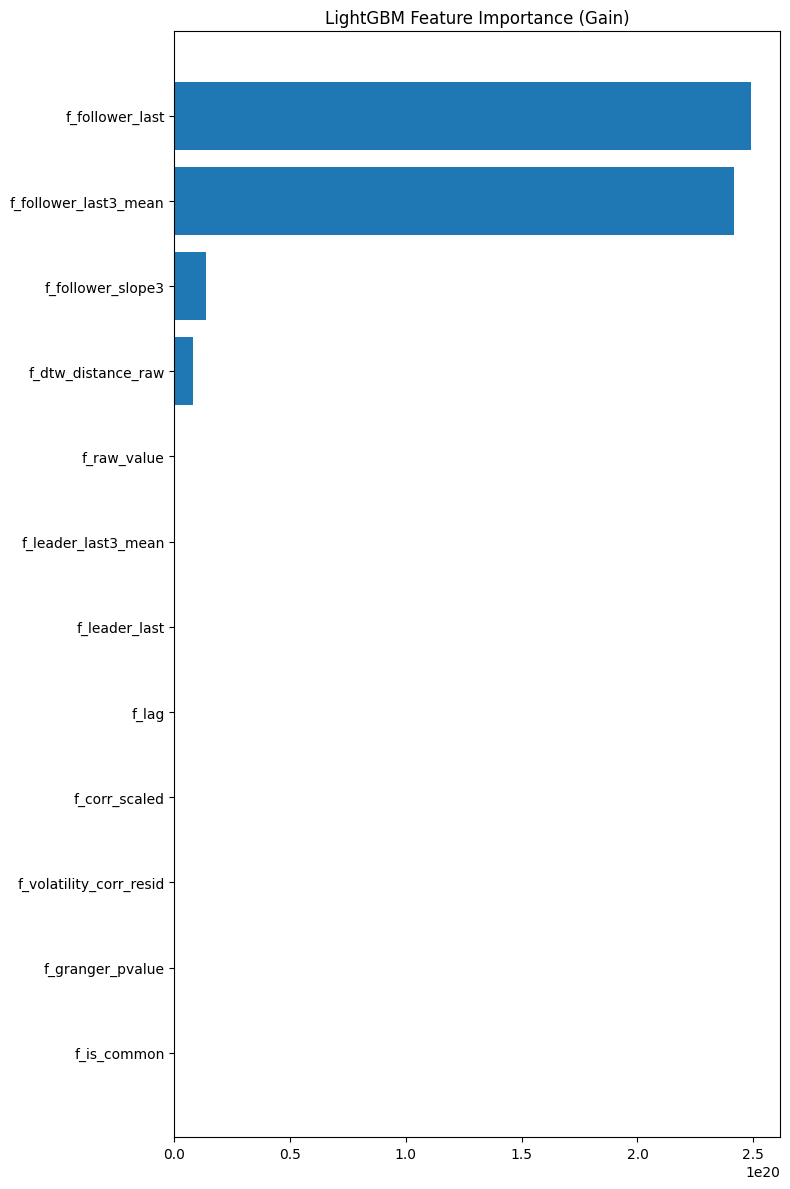

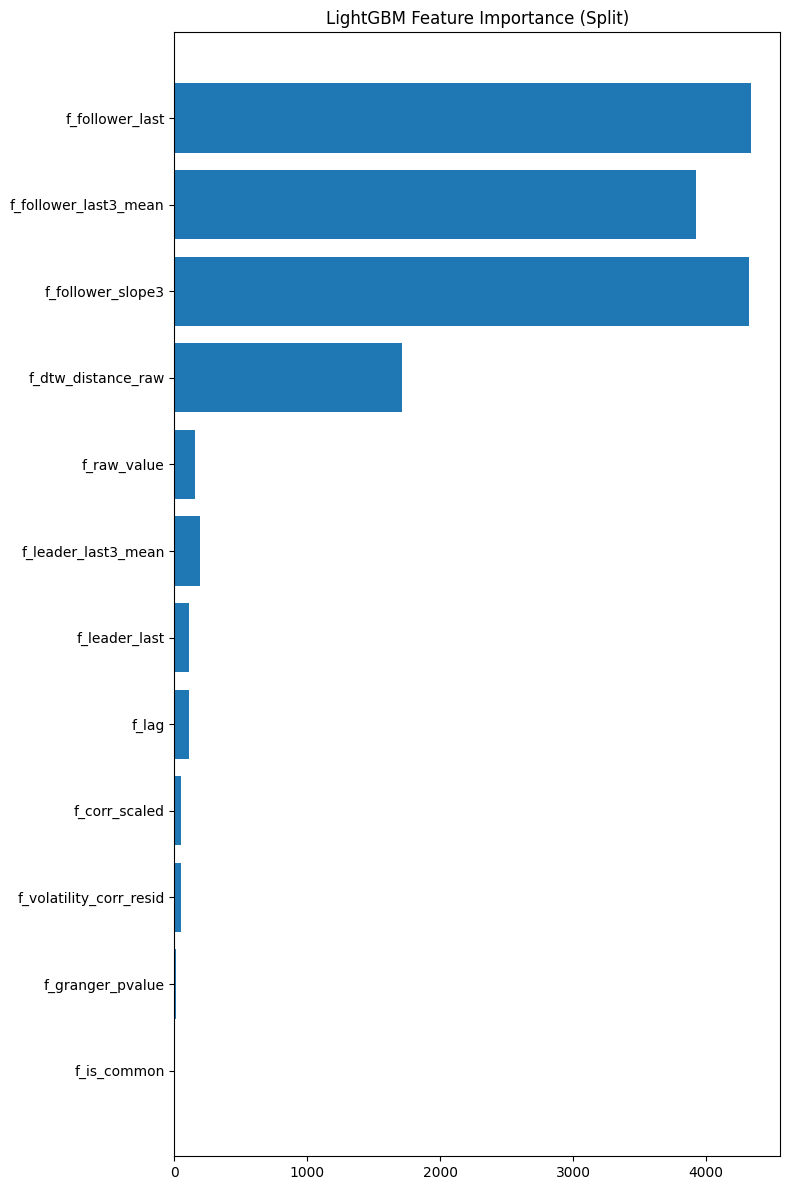

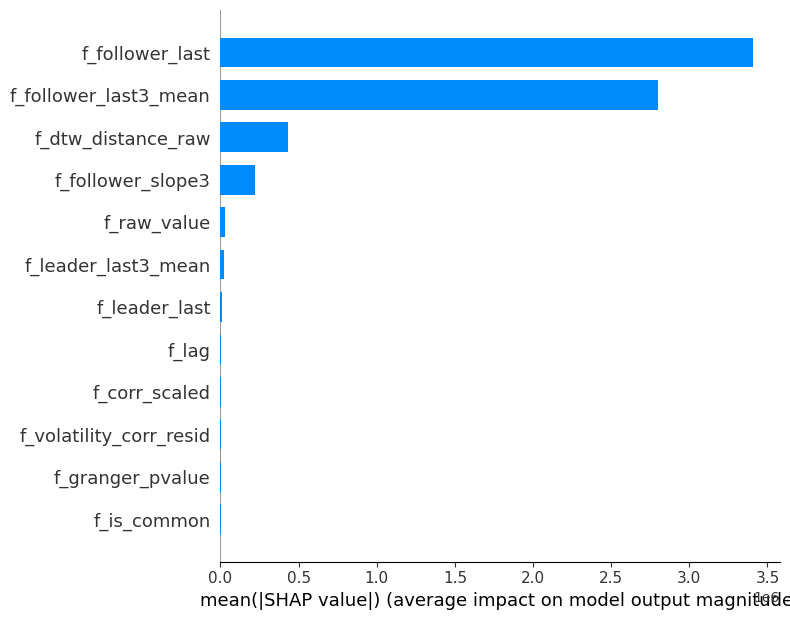

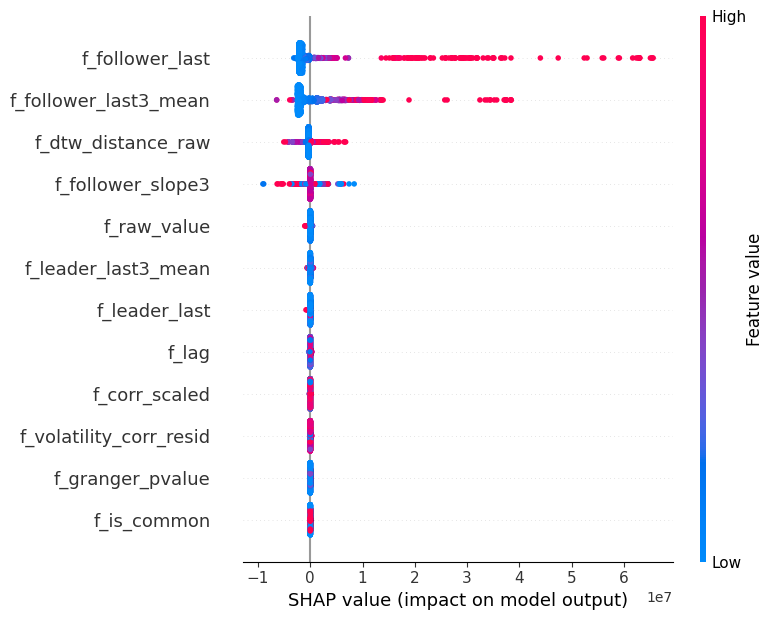

=== 예측 시작 ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

LGBM 제출용 예측 완료. hs_20251119_050051.csv 저장됨.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

In [32]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
from lightgbm import LGBMRegressor

# dtw + shap (있으면 사용)
try:
    from tslearn.metrics import dtw
    import shap
except:
    pass

# ============================================================
# A-Version: Dynamic Feature 강화 버전
# ============================================================

def build_training_data_A(pivot, pairs_meta, months_dt):
    """
    제출용 학습데이터 생성

    Feature 구성:
      - f_raw_value            : leader 의 (t - lag) 시점 raw value   (dynamic)
      - f_is_common            : raw & resid 교집합 pair 여부(0/1)
      - f_lag                  : best_lag

      - f_corr_scaled          : log1p(|corr_raw|) * sign(corr_raw)
      - f_corr_raw             : 원본 max_corr

      - f_dtw_distance_raw     : DTW 거리
      - f_granger_pvalue       : Granger p-value
      - f_volatility_corr_resid: residual volatility corr
      - f_is_common            : raw값, resid값 양쪽 기준 둘다 공행성 쌍 판별된 유무

      # 최신 경향 반영
      - f_leader_last          : 공행성 선행품목의 가장 최신 직전달 값
      - f_leader_last3_mean    : 공행성 선행품목의 가장 최신 직전 3달 평균값
      - f_follower_last        : 공행성 예측(후행)품목의 가장 최신 직전달 값
      - f_follower_last3_mean  : 공행성 예측(후행)품목의 가장 최신 직전 3달 평균값
      - f_follower_slope3      :


    """
    months = months_dt
    n_months = len(months)
    rows = []

    for row in pairs_meta.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.f_lag)

        for t in range(lag, n_months - 1):
            ref_idx = t - lag
            target_month = months[t + 1]
            ref_month = months[ref_idx]

            # leader raw
            L_raw = pivot.loc[leader, ref_month]

            # leader last / last3 mean
            L_last = pivot.loc[leader, months[t]]
            L_last3 = pivot.loc[leader, months[max(0, t-2):t+1]].mean()

            # follower last / last3 mean
            F_last = pivot.loc[follower, months[t]]
            F_last3 = pivot.loc[follower, months[max(0, t-2):t+1]].mean()

            # follower mini-slope
            F_vals = pivot.loc[follower, months[max(0, t-2):t+1]].values
            if len(F_vals) >= 3:
                F_slope = (F_vals[-1] - F_vals[0]) / 3
            else:
                F_slope = 0

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_month": target_month,
                "value": pivot.loc[follower, target_month],

                # dynamic features
                "f_raw_value": L_raw,
                "f_leader_last": L_last,
                "f_leader_last3_mean": L_last3,
                "f_follower_last": F_last,
                "f_follower_last3_mean": F_last3,
                "f_follower_slope3": F_slope,

                # static meta
                "f_is_common": row.f_is_common,
                "f_lag": row.f_lag,
                "f_corr_scaled": row.f_corr_scaled,
                "f_dtw_distance_raw": row.f_dtw_distance_raw,
                "f_granger_pvalue": row.f_granger_pvalue,
                "f_volatility_corr_resid": row.f_volatility_corr_resid
            })
    return pd.DataFrame(rows)

feature_cols = [
    "f_raw_value",
    "f_leader_last",
    "f_leader_last3_mean",
    "f_follower_last",
    "f_follower_last3_mean",
    "f_follower_slope3",
    "f_is_common",
    "f_lag",
    "f_corr_scaled",
    "f_dtw_distance_raw",
    "f_granger_pvalue",
    "f_volatility_corr_resid"
]

print("=== 학습 시작 ===")
dfA = build_training_data_A(pivot, pairs_meta, months_dt)

print('생성된 학습 데이터의 shape :', dfA.shape)

if dfA.empty:
    print("오류: 학습 데이터가 없습니다.")
    submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
else:
    train_X = dfA[feature_cols].values
    train_y = dfA["value"].values

    # ⚠️ 절대 수정 금지: 원래 쓰던 LGBM 정의 그대로
    reg = LGBMRegressor(random_state=42, n_estimators=500, learning_rate= 0.01)
    print("LGBMRegressor 모델(7개 feature) 학습 시작...")
    reg.fit(train_X, train_y)
    print("모델 학습 완료.")

    # importance data
    importance_gain = reg.booster_.feature_importance(importance_type='gain')
    importance_split = reg.booster_.feature_importance(importance_type='split')
    feature_names = feature_cols

    # 정렬
    idx = np.argsort(importance_gain)

    plt.figure(figsize=(8, 12))
    plt.barh(np.array(feature_names)[idx], importance_gain[idx])
    plt.title("LightGBM Feature Importance (Gain)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 12))
    plt.barh(np.array(feature_names)[idx], importance_split[idx])
    plt.title("LightGBM Feature Importance (Split)")
    plt.tight_layout()
    plt.show()

    # ------------------------------------
    # 🔍 SHAP Feature Importance (전역 중요도)
    # ------------------------------------
    import shap
    import numpy as np

    # SHAP 계산 시 표본 일부만 샘플링해서 메모리 절약
    sample_size = min(2000, len(train_X))
    idx = np.random.choice(len(train_X), sample_size, replace=False)

    X_sample = train_X[idx]

    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X_sample)

    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type="bar")
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols)


print("=== 예측 시작 ===")

preds = []
t_last = len(months_dt) - 1

for row in pairs_meta.itertuples(index=False):
    leader = row.leading_item_id
    follower = row.following_item_id
    lag = int(row.f_lag)

    ref_idx = t_last - lag
    ref_month = months_dt[ref_idx]

    # dynamic
    L_raw = pivot.loc[leader, ref_month]
    L_last = pivot.loc[leader, months_dt[t_last]]
    L_last3 = pivot.loc[leader, months_dt[max(0, t_last-2):t_last+1]].mean()
    F_last = pivot.loc[follower, months_dt[t_last]]
    F_last3 = pivot.loc[follower, months_dt[max(0, t_last-2):t_last+1]].mean()

    F_vals = pivot.loc[follower, months_dt[max(0, t_last-2):t_last+1]].values
    if len(F_vals) >= 3:
        F_slope = (F_vals[-1] - F_vals[0]) / 3
    else:
        F_slope = 0

    Xrow = np.array([[
        L_raw, L_last, L_last3, F_last, F_last3, F_slope,
        row.f_is_common, row.f_lag, row.f_corr_scaled,
        row.f_dtw_distance_raw, row.f_granger_pvalue,
        row.f_volatility_corr_resid
    ]])

    pred = reg.predict(Xrow)[0]
    pred = int(max(0, round(pred)))

    preds.append({
        "leading_item_id": leader,
        "following_item_id": follower,
        "value": pred
    })

# 최종 제출 파일 저장
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"hs_{date_str}.csv"
submission = pd.DataFrame(preds)
submission.to_csv(file_name, index=False)
print(f"LGBM 제출용 예측 완료. {file_name} 저장됨.")